**Porcentaje de población de la ZM Ciudad de México que se siente inseguro en el transporte público**

In [ ]:
#Borrar entorno
#rm(list=ls())

# Librerías necesarias====
#if(!require('pacman')) install.packages('pacman')
pacman::p_load(modeest,
  tidyverse, srvyr, showtext,survey)

In [33]:
#Función para leer los datos de la ENVIPE
leer_envipe_vic <- function(anios) {

  anios <- as.integer(anios)[anios %in% 2016:2024]
  

  data_list <- list()

  for (anio in anios) {
    url <- paste0("https://www.inegi.org.mx/contenidos/programas/envipe/",
                  anio,
                 "/microdatos/bd_envipe",
                 ifelse(anio < 2020, anio, paste0("_", anio)),
                 "_dbf.zip")

    temp_zip <- tempfile(fileext = ".zip")
    temp_dir <- tempdir()
    options(timeout = 1000)

    result <- download.file(url, temp_zip, mode = "wb", quiet = TRUE)
              unzip(temp_zip, exdir = temp_dir)

    nombre <- list.files(temp_dir, pattern = "TPer_Vic1.dbf", 
                             full.names = TRUE, recursive = TRUE)

  
    datos <- foreign::read.dbf(nombre)|>
           mutate(inse_t_publico = case_when(AP4_4_09 == "1" ~ "Se siente seguro", 
                                      AP4_4_09 == "2" ~ "Se siente inseguro", 
                                      TRUE ~ "No responde"), 
                  FAC_ELE_AM= as.numeric(FAC_ELE_AM))|>
                  filter(AREAM == "01",
                          AP4_4_09!=3)
                         
#Poner los datos en una lista
    data_list[[as.character(anio)]] <- datos

    # Limpiar archivos temporales
    unlink(temp_zip)
    unlink(list.files(temp_dir, full.names = TRUE), recursive = TRUE)
  }

  return(data_list)
}

In [34]:
# Función para definir diseño muestral
diseño_muestral_l <- function(lista_datos) {
  
  lista_dm <- list()

  for (anio in names(lista_datos)) {
    datos <- lista_datos[[anio]]

    diseño <- datos|>
      as_survey_design(strata = EST_DIS,
                       weights = FAC_ELE_AM,
                       ids = UPM_DIS,
                        nest = TRUE)

    lista_dm[[anio]] <- diseño 
  }

  return(lista_dm)
}

In [35]:
#Obtener porcentajes y totales con coeficiente de variación
resultados_inseguridad <- function(anio) {
  datos <- get(paste0("inseg_tp_", anio))
  
  datos_dm <- datos |>
    group_by(inse_t_publico) |>
    summarise(tot_p_inseg_tp = survey_total(vartype = "cv"),
              porcentaje = survey_prop(vartype = "cv") * 100)|>
    filter(inse_t_publico == "Se siente inseguro")|>
    select(inse_t_publico, porcentaje, porcentaje_cv)|>
    mutate(ano = anio)
  
  return(datos_dm)
}

In [36]:
#Función para obtener los porcentajes y totales con coeficiente de variación
resultados_inseguridad <- function(lista_c_dm) {

  resultados_l <- list()

  for (anio in names(lista_c_dm)) {
    datos <- lista_c_dm[[anio]]
  
  resultados <- datos|>
    group_by(inse_t_publico) |>
    summarise(tot_p_inseg_tp = survey_total(vartype = "cv"),
              porcentaje = survey_prop(vartype = "cv") * 100)|>
    filter(inse_t_publico == "Se siente inseguro")|>
    select(inse_t_publico, porcentaje, porcentaje_cv)|>
    mutate(ano = as.integer(anio),
           tipo = "Observado")

    resultados_l[[anio]] <- resultados 
  }
  return(resultados_l)
}

In [37]:
#Leer datos de la ENVIPE
lista_envipe_vic <- leer_envipe_vic(2016:2024)

In [38]:
# Crear lista de diseño muestral para cada serie
lista_dm <- diseño_muestral_l(lista_envipe_vic)

In [39]:
# Aplica la función a la lista de diseños muestrales
resultados_envipe <- resultados_inseguridad(lista_dm)
#Convertir la lista a un data frame
inseguridad_transporte_publico <- bind_rows(resultados_envipe, .id = "anio")
#Mostrar los resultados
inseguridad_transporte_publico

inseguridad_transporte_publico<-inseguridad_transporte_publico|>
select(porcentaje, ano)|>
  mutate(tipo = "Observado")

anio,inse_t_publico,porcentaje,porcentaje_cv,ano,tipo
<chr>,<chr>,<dbl>,<dbl>,<int>,<chr>
2016,Se siente inseguro,90.94581,0.6132194,2016,Observado
2017,Se siente inseguro,92.50218,0.3863297,2017,Observado
2018,Se siente inseguro,92.36783,0.3965389,2018,Observado
2019,Se siente inseguro,92.73426,0.3918301,2019,Observado
2020,Se siente inseguro,90.02955,0.4782366,2020,Observado
2021,Se siente inseguro,90.47556,0.5534886,2021,Observado
2022,Se siente inseguro,90.18854,0.5276182,2022,Observado
2023,Se siente inseguro,85.69889,0.6179784,2023,Observado
2024,Se siente inseguro,82.13023,0.6602219,2024,Observado


In [40]:
inseguridad_transporte_publico_2024 <- inseguridad_transporte_publico |> filter(ano == 2024)
inseguridad_transporte_publico_2016 <- inseguridad_transporte_publico |> filter(ano == 2016)


In [41]:
##ESCENARIOS TENDENCIALES 2030,2035,2045
# Tasa de variación
tcma<-((inseguridad_transporte_publico_2024$porcentaje /inseguridad_transporte_publico_2016$porcentaje)^(1/(2024-2016)) - 1) 
tcma

inseguridad_transporte_publico_base <- inseguridad_transporte_publico |>
  filter(ano == 2024) |>
  pull(porcentaje)

inseguridad_transporte_publico_base

# Años a proyectar
años <- c(2030,2035,2045)
año_base <- 2024

tendencia_base <- data.frame(ano = años,
                             porcentaje = round(inseguridad_transporte_publico_base * (1 + -1/3*tcma) ^ (años - año_base), 2),
                             tipo = "Inercial")


tendecia_deseable<-data.frame(ano = años,
                              porcentaje = round(inseguridad_transporte_publico_base * (1 + 1/2*tcma) ^ (años - año_base), 2),
                              tipo = "Deseable")


tendecia_transformadora <-data.frame(ano = años,
                                     porcentaje = round(inseguridad_transporte_publico_base * (1 + 3/4*tcma) ^ (años - año_base), 2),
                                     tipo = "Transformador")


inseguridad_transporte_tendencias <- inseguridad_transporte_publico|>
  bind_rows(tendencia_base,tendecia_deseable, 
            tendecia_transformadora)|>
  select(ano, porcentaje, tipo)

inseguridad_transporte_tendencias


[1] -0.01266384

[1] 82.13023

ano,porcentaje,tipo
<dbl>,<dbl>,<chr>
2016,90.94581,Observado
2017,92.50218,Observado
2018,92.36783,Observado
2019,92.73426,Observado
2020,90.02955,Observado
2021,90.47556,Observado
2022,90.18854,Observado
2023,85.69889,Observado
2024,82.13023,Observado


In [42]:
lineas <- bind_rows(data.frame(ano = c(2024, 2030),
                               porcentaje = c(inseguridad_transporte_tendencias$porcentaje[inseguridad_transporte_tendencias$ano == 2024 & inseguridad_transporte_tendencias$tipo == "Observado"],
                                                            inseguridad_transporte_tendencias$porcentaje[inseguridad_transporte_tendencias$ano == 2030 & inseguridad_transporte_tendencias$tipo == "Inercial"]),
                               tipo = "Inercial"),
                    data.frame(ano = c(2024, 2030),
                               porcentaje = c(inseguridad_transporte_tendencias$porcentaje[inseguridad_transporte_tendencias$ano == 2024 & inseguridad_transporte_tendencias$tipo == "Observado"], 
                                                            inseguridad_transporte_tendencias$porcentaje[inseguridad_transporte_tendencias$ano == 2030 & inseguridad_transporte_tendencias$tipo == "Deseable"]),
                               tipo = "Deseable"), 
                    data.frame(ano = c(2024, 2030),
                               porcentaje = c(inseguridad_transporte_tendencias$porcentaje[inseguridad_transporte_tendencias$ano == 2024 & inseguridad_transporte_tendencias$tipo == "Observado"], 
                                                            inseguridad_transporte_tendencias$porcentaje[inseguridad_transporte_tendencias$ano == 2030 & inseguridad_transporte_tendencias$tipo == "Transformador"]),
                               tipo = "Transformador"))


paleta_colores <- c("Observado" = "#9F2241",
                    "Inercial" = "#cfcfcf" ,
                    "Deseable" = "#027A35", 
                    "Transformador" = "#AC6D14")

linetypes <- c("Observado" = "solid",
               "Inercial" = "dotdash",
               "Deseable" = "dotdash", 
               "Transformador" = "dotdash")


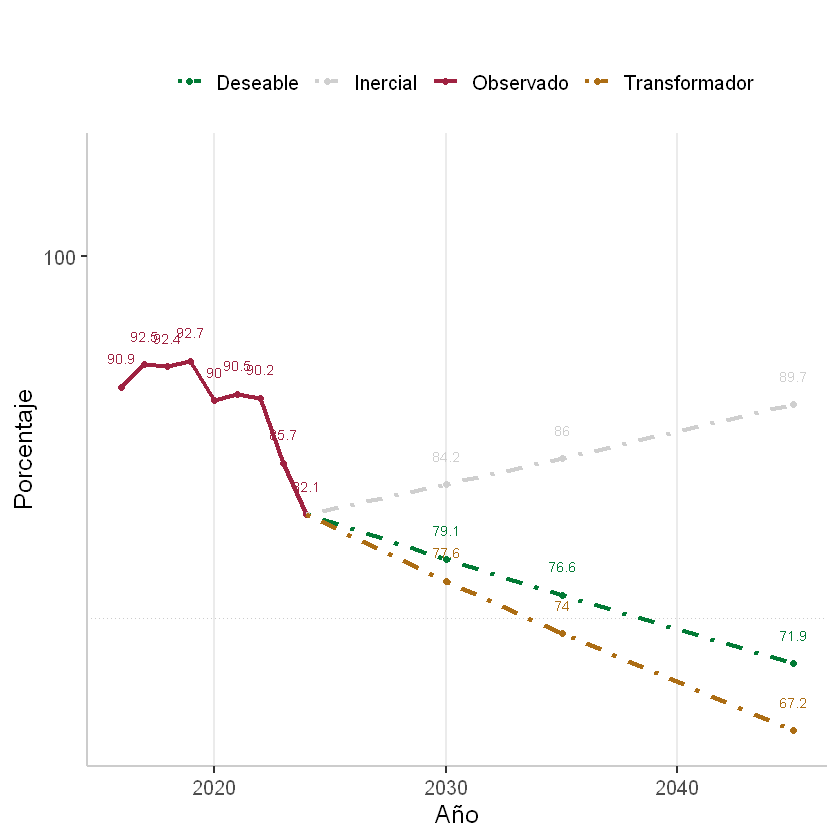

In [43]:
# Gráfico con etiquetas y eje Y personalizado
ggplot(inseguridad_transporte_tendencias, aes(x = ano, y = porcentaje, group = tipo, color = tipo, linetype = tipo)) +
  geom_line(linewidth = 1.2) +
  geom_point(size = 1.5) +
  geom_line(data = lineas, aes(x = ano, y = porcentaje, group = tipo), linewidth = 1.2) +
  geom_text(aes(label = round(porcentaje, 1)),
            position = position_nudge(y = 2),
            size = 3, show.legend = FALSE) +
  scale_color_manual(values = paleta_colores) +
  scale_linetype_manual(values = linetypes) +
  scale_y_continuous(breaks = seq(0, max(inseguridad_transporte_tendencias$porcentaje, na.rm = TRUE) +100, by = 50),
                     labels = function(x) paste0(x, ""),
                     expand = expansion(mult = c(0.09,0.5))) +
  labs(title = "",
       x = "Año",
       y = "Porcentaje",
       color = "",
       linetype = "") +
  theme_bw(base_size = 15) +
  theme( panel.grid.minor.y = element_line(color = "gray80", linetype = "dotted"),
         panel.grid.minor.x = element_blank(),
         panel.grid.major.y = element_blank(),
         panel.border = element_blank(),
         axis.line = element_line(color = "gray80"),
         legend.position = "top",
         plot.caption = element_text(hjust = 100))

#ggsave("inseguridad_transporte_tendencias.png", width = 8, height = 5, dpi = 300)